импорты в одном месте

In [92]:
import zipfile
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from collections import Counter
import matplotlib.pyplot as plt
import random
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision
import cv2
import torch.nn.init as init
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


0. распакуем нашу папку тест (и трейн)

In [4]:
fname = "./test.zip"
path = "./"

with zipfile.ZipFile(fname, "r") as zf:
    for entry in tqdm(zf.infolist(), desc="Extracting"):
        try:
            zf.extract(entry, path)
        except zipfile.error as e:
            pass

FileNotFoundError: [Errno 2] No such file or directory: './test.zip'

0. посмотрим на классы, всё ок!

In [93]:
print("Классы:", os.listdir("./train"))

Классы: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


#### 1. Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы. (0.5 балла).

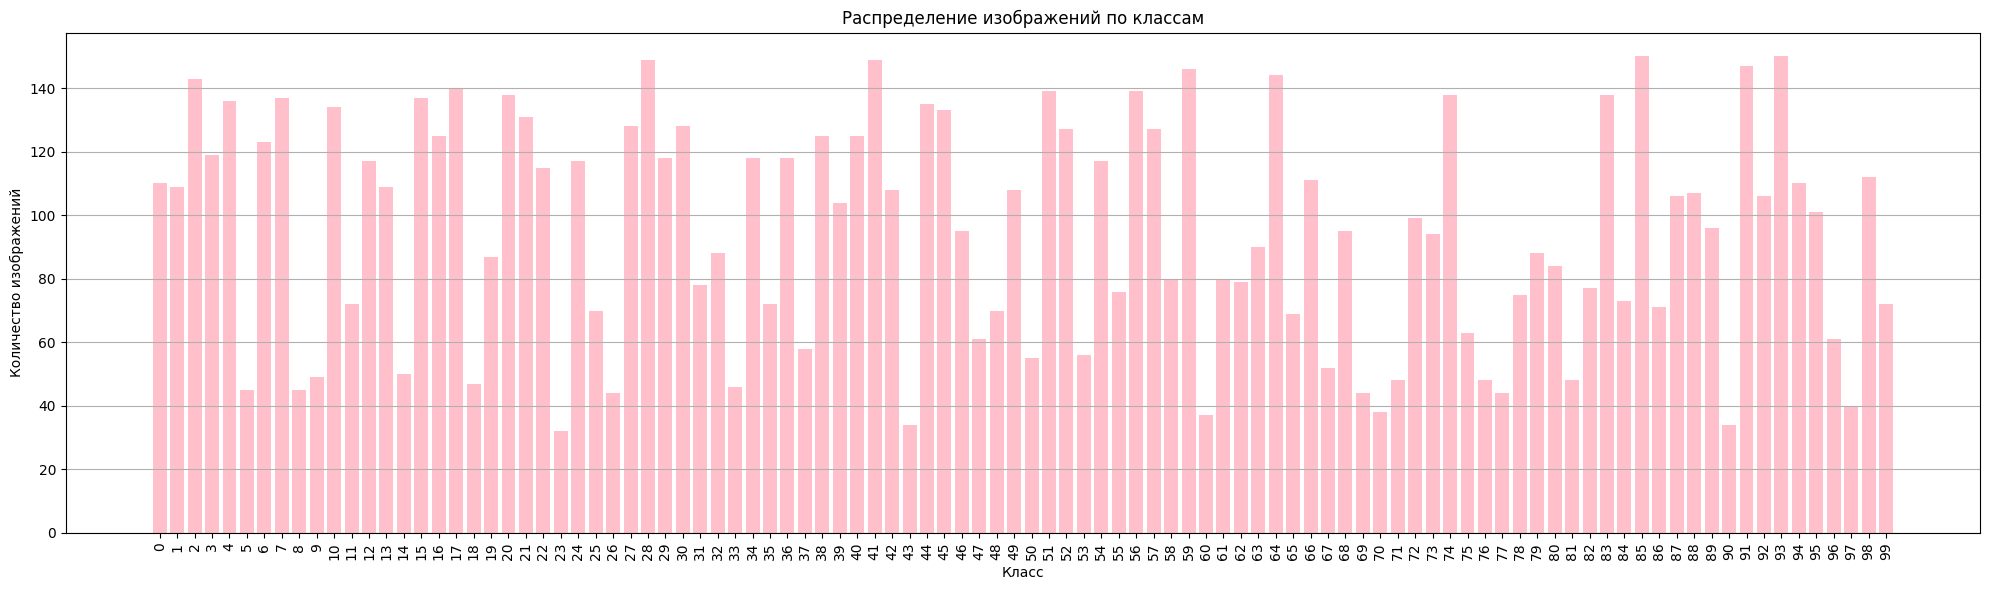

In [7]:
data_dir = "./train"
class_counts = {}

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path) and class_name.isdigit():
        image_count = len(os.listdir(class_path))
        class_counts[int(class_name)] = image_count  
# Сортируем по числам
sorted_classes = sorted(class_counts.items())
class_ids = [str(k) for k, v in sorted_classes] # Разбиваем на 2 списка: классы и значения
counts = [v for k, v in sorted_classes]


plt.figure(figsize=(20, 6))
plt.bar(class_ids, counts, color="pink")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

качество, конечно, шакальное, но что поделать... в целом понятно, что изображено.

на рандоме выпал 8 класс и к нему, конечно, вопросик: там вроде как изображение девушек должны быть, но откуда-то взялся рисунок мартышки до кучи. есть подозрение, что подобные мемы не только в 8 классе, надо бы придумать способ подобное почистить. условно в каждом классе сравнить между собой изображения (возможно ли это?)

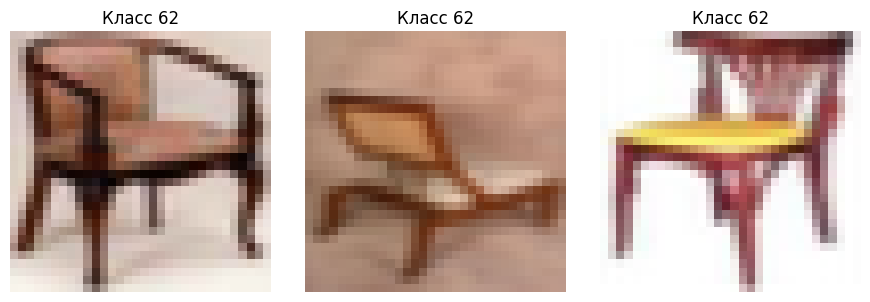

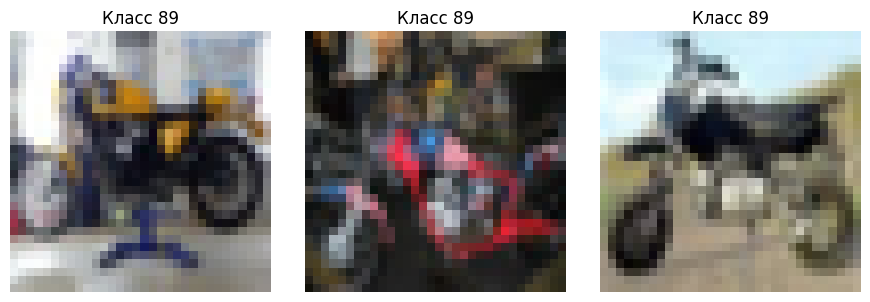

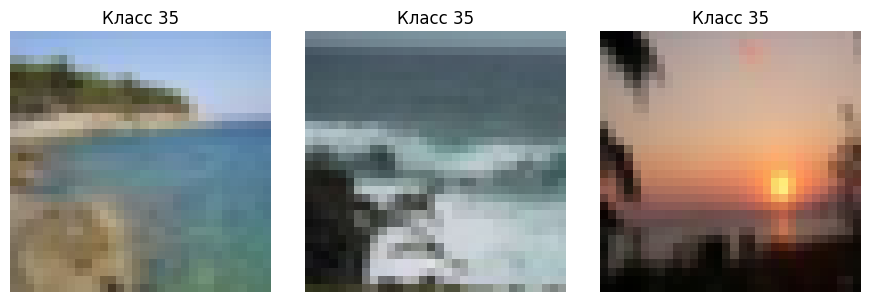

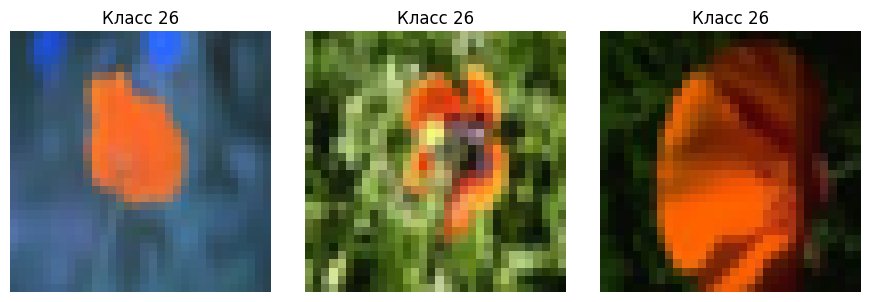

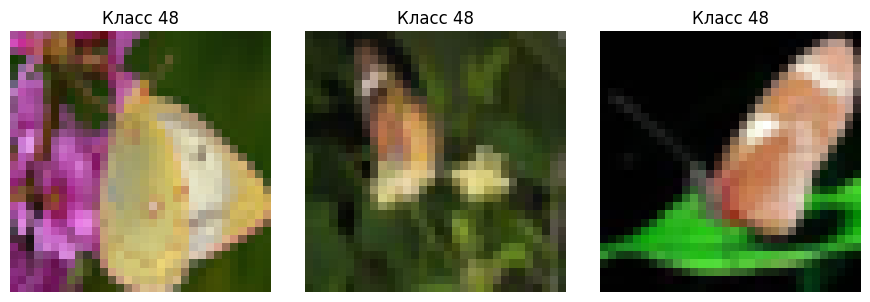

In [69]:
def visualization(class_id, data_dir="./train", n=3):
    class_id_str = str(class_id)  # преобразуем в строку
    class_path = os.path.join(data_dir, class_id_str)
    images = os.listdir(class_path)
    samples = random.sample(images, min(n, len(images)))

    plt.figure(figsize=(n * 3, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Класс {class_id}")
    plt.tight_layout()
    plt.show()

sample_classes = random.sample(list(class_counts.keys()), 5)
for cls in sample_classes:
    visualization(cls)

выводы:

1) распределение по классам не равномерное, явно видно на графике
2) в классах могут быть изображения, которые не соответствуют классу (класс 8, например) -> эту проблему нужно учитывать. 

#### 2. Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель. (1.5 балла).

нужно разобрать подбор параметров для аугментации. и еще возможно, в начале нужно подумать, что делать с ошибочными изображениями в классах.

In [70]:
IMG_SIZE = 224  
train_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),  
        # Геометрия
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.2, rotate_limit=25, p=0.7, border_mode=0
        ),
        A.ElasticTransform(
            alpha=1, sigma=50, alpha_affine=20, p=0.2
        ),  
        # Цвет и освещение
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.4),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
        # Шумы и эффекты
        A.GaussianBlur(p=0.2),
        A.MotionBlur(p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, p=0.3
        ),  # затирание части изображения
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [71]:
class custom_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = [
            (os.path.join(root_dir, cls, fname), idx)
            for idx, cls in enumerate(sorted(os.listdir(root_dir)))
            for fname in os.listdir(os.path.join(root_dir, cls))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = np.array(Image.open(path).convert('RGB'))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

In [72]:
train_dataset = custom_dataset(root_dir="./train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

тут я решила посмотреть, что у меня произошло с моим многострадальным датасетом после всех моих пыток. но из-за нормализации, картинки выглядят так затемненно - особенности отображения. НО если ее закоментить выше, в аугментации, то в целом всё гуд, цвета приличные

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


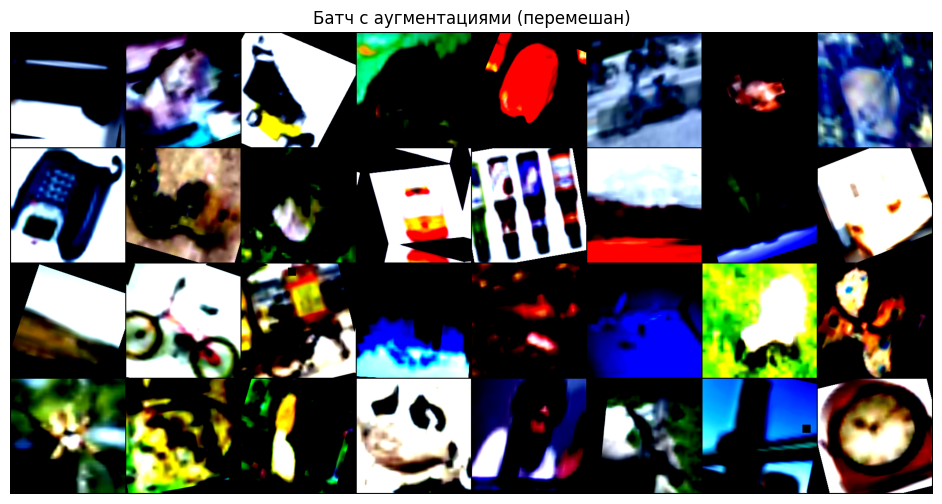

Метки классов: [84, 31, 95, 64, 60, 39, 34, 13, 68, 38, 82, 65, 65, 4, 12, 84, 24, 39, 39, 4, 9, 20, 91, 43, 34, 15, 56, 61, 93, 61, 41, 53]


In [73]:
images, labels = next(iter(train_loader))
def denormalize(tensor):
    tensor = tensor.clone()
    return tensor
plt.figure(figsize=(12, 6))
img = torchvision.utils.make_grid(denormalize(images[:32]), nrow=8)
plt.imshow(img.permute(1, 2, 0))
plt.title("Батч с аугментациями (перемешан)")
plt.axis("off")
plt.show()

# Показываем метки
print("Метки классов:", labels[:32].tolist())

тут я игралась с аугментациями и смотрела, что с картинками происходит. ну а что, фотошоп на коленке...

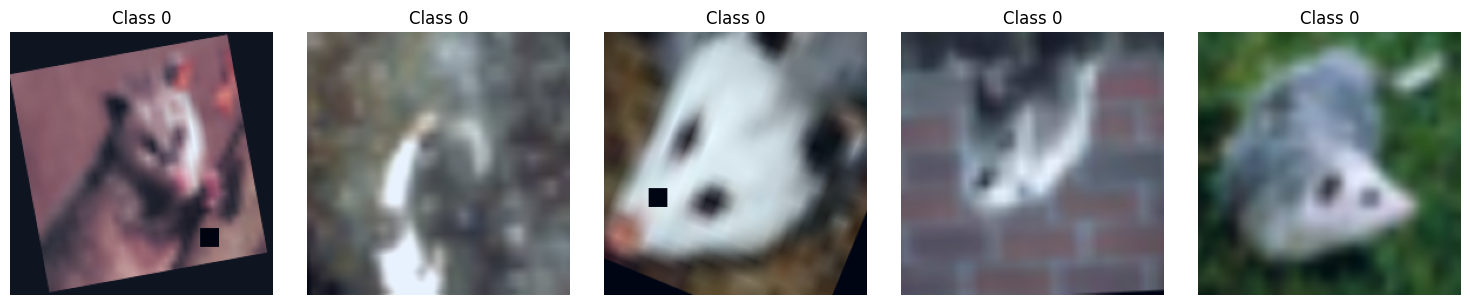

In [74]:
def visualize_batch(dataset, num_images=5):
    plt.figure(figsize=(num_images * 3, 3))
    
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Class {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
visualize_batch(train_dataset)

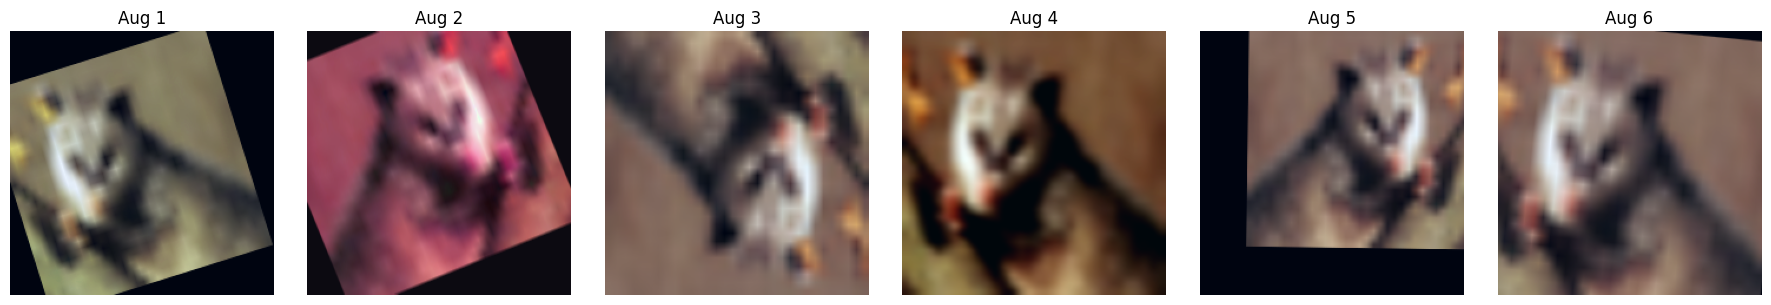

In [75]:
def visualize_augmentations(image_path, transform, num_augmented=6):
    img = np.array(Image.open(image_path).convert('RGB'))
    
    plt.figure(figsize=(num_augmented * 3, 3))
    
    for i in range(num_augmented):
        aug = transform(image=img)['image']
        aug = aug.permute(1, 2, 0).cpu().numpy()
        aug = (aug - aug.min()) / (aug.max() - aug.min())
        
        plt.subplot(1, num_augmented, i + 1)
        plt.imshow(aug)
        plt.title(f'Aug {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

sample_image_path = train_dataset.samples[0][0]
visualize_augmentations(sample_image_path, train_transform, num_augmented=6)


что в тесте?

In [76]:
test_folder = 'test'
image_files = [f for f in os.listdir(test_folder) if f.endswith('.png')]
sorted_images = sorted(image_files, key=lambda x: int(os.path.splitext(x)[0]))
sorted_image_paths = [os.path.join(test_folder, img) for img in sorted_images]
for path in sorted_image_paths:
    print(path)


test/0.png
test/1.png
test/2.png
test/3.png
test/4.png
test/5.png
test/6.png
test/7.png
test/8.png
test/9.png
test/10.png
test/11.png
test/12.png
test/13.png
test/14.png
test/15.png
test/16.png
test/17.png
test/18.png
test/19.png
test/20.png
test/21.png
test/22.png
test/23.png
test/24.png
test/25.png
test/26.png
test/27.png
test/28.png
test/29.png
test/30.png
test/31.png
test/32.png
test/33.png
test/34.png
test/35.png
test/36.png
test/37.png
test/38.png
test/39.png
test/40.png
test/41.png
test/42.png
test/43.png
test/44.png
test/45.png
test/46.png
test/47.png
test/48.png
test/49.png
test/50.png
test/51.png
test/52.png
test/53.png
test/54.png
test/55.png
test/56.png
test/57.png
test/58.png
test/59.png
test/60.png
test/61.png
test/62.png
test/63.png
test/64.png
test/65.png
test/66.png
test/67.png
test/68.png
test/69.png
test/70.png
test/71.png
test/72.png
test/73.png
test/74.png
test/75.png
test/76.png
test/77.png
test/78.png
test/79.png
test/80.png
test/81.png
test/82.png
test/83.png
te

#### 3. Поделить данные на трейн-валидацию.            
обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение во горизонтали и вертикали) и с навороченными.              
Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning.              
Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле).              
Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (4.5 балла)

3.1 для начала надо поделить как-то на трейн и валидационную, чтобы при этом баланс классов сохранился и с метками всё ок было.          
в любой ситуации делай кастомную функцию и надейся, что это адекватно...


train_samples: список путей к изображениям + метки

val_samples: то же самое для валидации

class_to_idx: словарь вида {класс_в_папке: индекс} — нужен для label-ов



In [77]:
def split_dataset(root_dir, val_size=0.2, random_state=42):
    samples = []
    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(root_dir)))}

    for class_name in class_to_idx:
        class_path = os.path.join(root_dir, class_name)
        for fname in os.listdir(class_path):
            path = os.path.join(class_path, fname)
            label = class_to_idx[class_name]
            samples.append((path, label))

    train_samples, val_samples = train_test_split(
        samples,
        test_size=val_size,
        stratify=[s[1] for s in samples],
        random_state=random_state,
    )

    return train_samples, val_samples, class_to_idx

In [78]:
train_samples, val_samples, class_to_idx = split_dataset("./train")

In [79]:
##train_samples
##class_to_idx

In [80]:
class CustomDatasetFromSamples(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

In [81]:
basic_transform = A.Compose(
    [
        A.Resize(224, 224),  # апскейлинг для моделей типа ResNet и тд :)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

апскейлинг тут применен для transfer learning. картинку делаем 224*224      

но этот просто как шаблон, его дорабатывать ниже буду.

In [82]:
IMG_SIZE = 224  

advanced_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),  
        # Геометрия
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.2, rotate_limit=25, p=0.7, border_mode=0
        ),
        # Цвет и освещение
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.4),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
        # Шумы и эффекты
        A.GaussianBlur(p=0.2),
        A.MotionBlur(p=0.2),
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, p=0.3
        ),  # затирание части изображения
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

## перейдем к моделям, начнем с базовой

In [83]:

train_dataset_basic = CustomDatasetFromSamples(train_samples, transform=basic_transform)
val_dataset_basic = CustomDatasetFromSamples(val_samples, transform=basic_transform)

train_loader_basic = DataLoader(
    train_dataset_basic, batch_size=64, shuffle=True, num_workers=2
)
val_loader_basic = DataLoader(
    val_dataset_basic, batch_size=64, shuffle=False, num_workers=2
)

In [84]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.gap(x)  
        x = x.view(x.size(0), -1) 
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### модель 1.1. база.

In [85]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(
            f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [25]:
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    return val_loss, val_acc

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=100)

train_model(model, train_loader_basic, val_loader_basic, device, epochs=50, lr=1e-3)

Epoch 1/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.39it/s]


Epoch 1/50 - Train Loss: 522.2788, Train Acc: 0.0386, Val Loss: 126.0771, Val Acc: 0.0473


Epoch 2/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.65it/s]


Epoch 2/50 - Train Loss: 492.6405, Train Acc: 0.0648, Val Loss: 122.0380, Val Acc: 0.0768


Epoch 3/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.99it/s]


Epoch 3/50 - Train Loss: 480.2365, Train Acc: 0.0824, Val Loss: 120.0068, Val Acc: 0.0852


Epoch 4/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.90it/s]


Epoch 4/50 - Train Loss: 471.5259, Train Acc: 0.0885, Val Loss: 118.6575, Val Acc: 0.0820


Epoch 5/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.75it/s]


Epoch 5/50 - Train Loss: 464.1713, Train Acc: 0.0969, Val Loss: 117.3577, Val Acc: 0.0952


Epoch 6/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.90it/s]


Epoch 6/50 - Train Loss: 458.6858, Train Acc: 0.1083, Val Loss: 116.0932, Val Acc: 0.1004


Epoch 7/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.82it/s]


Epoch 7/50 - Train Loss: 451.4948, Train Acc: 0.1141, Val Loss: 114.7031, Val Acc: 0.1094


Epoch 8/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.86it/s]


Epoch 8/50 - Train Loss: 446.7518, Train Acc: 0.1147, Val Loss: 114.1118, Val Acc: 0.1125


Epoch 9/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.91it/s]


Epoch 9/50 - Train Loss: 442.7279, Train Acc: 0.1229, Val Loss: 113.1058, Val Acc: 0.1209


Epoch 10/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.79it/s]


Epoch 10/50 - Train Loss: 439.6097, Train Acc: 0.1262, Val Loss: 112.5757, Val Acc: 0.1351


Epoch 11/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.89it/s]


Epoch 11/50 - Train Loss: 436.0711, Train Acc: 0.1295, Val Loss: 112.7356, Val Acc: 0.1246


Epoch 12/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.79it/s]


Epoch 12/50 - Train Loss: 432.9875, Train Acc: 0.1342, Val Loss: 112.1408, Val Acc: 0.1236


Epoch 13/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.85it/s]


Epoch 13/50 - Train Loss: 430.0349, Train Acc: 0.1366, Val Loss: 112.0746, Val Acc: 0.1272


Epoch 14/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.81it/s]


Epoch 14/50 - Train Loss: 428.2426, Train Acc: 0.1363, Val Loss: 111.5110, Val Acc: 0.1346


Epoch 15/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.86it/s]


Epoch 15/50 - Train Loss: 425.8367, Train Acc: 0.1417, Val Loss: 111.6433, Val Acc: 0.1367


Epoch 16/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.83it/s]


Epoch 16/50 - Train Loss: 423.6051, Train Acc: 0.1384, Val Loss: 111.8153, Val Acc: 0.1320


Epoch 17/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.65it/s]


Epoch 17/50 - Train Loss: 420.4777, Train Acc: 0.1459, Val Loss: 111.2722, Val Acc: 0.1330


Epoch 18/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.86it/s]


Epoch 18/50 - Train Loss: 419.6859, Train Acc: 0.1504, Val Loss: 110.8991, Val Acc: 0.1288


Epoch 19/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.63it/s]


Epoch 19/50 - Train Loss: 415.8400, Train Acc: 0.1513, Val Loss: 110.8591, Val Acc: 0.1272


Epoch 20/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.74it/s]


Epoch 20/50 - Train Loss: 415.0286, Train Acc: 0.1508, Val Loss: 110.2517, Val Acc: 0.1399


Epoch 21/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.80it/s]


Epoch 21/50 - Train Loss: 411.9187, Train Acc: 0.1547, Val Loss: 110.5202, Val Acc: 0.1456


Epoch 22/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.78it/s]


Epoch 22/50 - Train Loss: 411.0577, Train Acc: 0.1592, Val Loss: 110.1954, Val Acc: 0.1467


Epoch 23/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.95it/s]


Epoch 23/50 - Train Loss: 407.8665, Train Acc: 0.1567, Val Loss: 110.5676, Val Acc: 0.1388


Epoch 24/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.66it/s]


Epoch 24/50 - Train Loss: 406.5614, Train Acc: 0.1643, Val Loss: 109.7699, Val Acc: 0.1451


Epoch 25/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.67it/s]


Epoch 25/50 - Train Loss: 404.5554, Train Acc: 0.1621, Val Loss: 109.6587, Val Acc: 0.1435


Epoch 26/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.84it/s]


Epoch 26/50 - Train Loss: 403.3382, Train Acc: 0.1647, Val Loss: 109.8507, Val Acc: 0.1488


Epoch 27/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.81it/s]


Epoch 27/50 - Train Loss: 401.6019, Train Acc: 0.1685, Val Loss: 110.4847, Val Acc: 0.1388


Epoch 28/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.83it/s]


Epoch 28/50 - Train Loss: 399.9068, Train Acc: 0.1726, Val Loss: 109.6370, Val Acc: 0.1467


Epoch 29/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.40it/s]


Epoch 29/50 - Train Loss: 397.8837, Train Acc: 0.1709, Val Loss: 109.7674, Val Acc: 0.1388


Epoch 30/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.62it/s]


Epoch 30/50 - Train Loss: 394.8291, Train Acc: 0.1795, Val Loss: 110.5194, Val Acc: 0.1362


Epoch 31/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.80it/s]


Epoch 31/50 - Train Loss: 394.6706, Train Acc: 0.1795, Val Loss: 109.5890, Val Acc: 0.1546


Epoch 32/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.89it/s]


Epoch 32/50 - Train Loss: 392.9366, Train Acc: 0.1813, Val Loss: 109.5170, Val Acc: 0.1483


Epoch 33/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.12it/s]


Epoch 33/50 - Train Loss: 391.1834, Train Acc: 0.1861, Val Loss: 109.2556, Val Acc: 0.1498


Epoch 34/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.82it/s]


Epoch 34/50 - Train Loss: 388.5056, Train Acc: 0.1835, Val Loss: 109.3316, Val Acc: 0.1577


Epoch 35/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.64it/s]


Epoch 35/50 - Train Loss: 387.2971, Train Acc: 0.1909, Val Loss: 109.8759, Val Acc: 0.1498


Epoch 36/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.72it/s]


Epoch 36/50 - Train Loss: 384.2302, Train Acc: 0.1901, Val Loss: 109.5773, Val Acc: 0.1409


Epoch 37/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.92it/s]


Epoch 37/50 - Train Loss: 383.0175, Train Acc: 0.1932, Val Loss: 109.2645, Val Acc: 0.1472


Epoch 38/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.74it/s]


Epoch 38/50 - Train Loss: 381.8969, Train Acc: 0.1945, Val Loss: 109.1711, Val Acc: 0.1535


Epoch 39/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.63it/s]


Epoch 39/50 - Train Loss: 380.2836, Train Acc: 0.1961, Val Loss: 109.1884, Val Acc: 0.1567


Epoch 40/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.42it/s]


Epoch 40/50 - Train Loss: 379.0933, Train Acc: 0.1953, Val Loss: 109.0631, Val Acc: 0.1661


Epoch 41/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.39it/s]


Epoch 41/50 - Train Loss: 376.4112, Train Acc: 0.2015, Val Loss: 109.2125, Val Acc: 0.1588


Epoch 42/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.94it/s]


Epoch 42/50 - Train Loss: 374.2936, Train Acc: 0.2040, Val Loss: 108.4499, Val Acc: 0.1635


Epoch 43/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.87it/s]


Epoch 43/50 - Train Loss: 373.4314, Train Acc: 0.2060, Val Loss: 108.6254, Val Acc: 0.1625


Epoch 44/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.03it/s]


Epoch 44/50 - Train Loss: 370.5037, Train Acc: 0.2112, Val Loss: 109.2574, Val Acc: 0.1609


Epoch 45/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.69it/s]


Epoch 45/50 - Train Loss: 369.3171, Train Acc: 0.2085, Val Loss: 108.4774, Val Acc: 0.1483


Epoch 46/50 - Training: 100%|██████████| 119/119 [00:07<00:00, 14.94it/s]


Epoch 46/50 - Train Loss: 368.2610, Train Acc: 0.2186, Val Loss: 108.8928, Val Acc: 0.1640


Epoch 47/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.41it/s]


Epoch 47/50 - Train Loss: 366.2759, Train Acc: 0.2179, Val Loss: 108.3728, Val Acc: 0.1682


Epoch 48/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.81it/s]


Epoch 48/50 - Train Loss: 363.5547, Train Acc: 0.2204, Val Loss: 108.9365, Val Acc: 0.1725


Epoch 49/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.73it/s]


Epoch 49/50 - Train Loss: 361.8745, Train Acc: 0.2252, Val Loss: 108.5903, Val Acc: 0.1651


Epoch 50/50 - Training: 100%|██████████| 119/119 [00:08<00:00, 14.71it/s]


Epoch 50/50 - Train Loss: 361.5421, Train Acc: 0.2190, Val Loss: 108.0206, Val Acc: 0.1740


### модель 1.2. 

In [57]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            init.zeros_(m.bias)
# Добавила learning rate scheduler и раннюю остановку
def train_model_with_callbacks(
    model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3
):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #  learning rate scheduler
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # уменьшать lr каждые 5 эпох
    # Ранняя остановка
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.apply(init_weights)

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучение
        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # После обучения эпохи
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0  # сброс счетчика
        else:
            patience_counter += 1

        # Ранняя остановка
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Обновление learning rate
        scheduler.step()

    # графиков
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [58]:
# Функция для оценки модели
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    return val_loss / len(val_loader), val_acc

In [59]:
# Функция для построения графиков
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Лосс график
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Точность график
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10 - Training: 100%|██████████| 119/119 [00:18<00:00,  6.42it/s]


Epoch 1/10 - Train Loss: 4.4463, Train Acc: 0.0339, Val Loss: 4.2298, Val Acc: 0.0631


Epoch 2/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.67it/s]


Epoch 2/10 - Train Loss: 4.2090, Train Acc: 0.0591, Val Loss: 4.1029, Val Acc: 0.0778


Epoch 3/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.89it/s]


Epoch 3/10 - Train Loss: 4.0970, Train Acc: 0.0727, Val Loss: 4.0277, Val Acc: 0.0846


Epoch 4/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.78it/s]


Epoch 4/10 - Train Loss: 4.0234, Train Acc: 0.0850, Val Loss: 3.9715, Val Acc: 0.0988


Epoch 5/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.89it/s]


Epoch 5/10 - Train Loss: 3.9621, Train Acc: 0.0956, Val Loss: 3.9413, Val Acc: 0.0973


Epoch 6/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.85it/s]


Epoch 6/10 - Train Loss: 3.9034, Train Acc: 0.0992, Val Loss: 3.9080, Val Acc: 0.0983


Epoch 7/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.82it/s]


Epoch 7/10 - Train Loss: 3.8585, Train Acc: 0.1028, Val Loss: 3.8675, Val Acc: 0.1046


Epoch 8/10 - Training: 100%|██████████| 119/119 [00:08<00:00, 13.65it/s]


Epoch 8/10 - Train Loss: 3.8279, Train Acc: 0.1063, Val Loss: 3.8505, Val Acc: 0.1141


Epoch 9/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.84it/s]


Epoch 9/10 - Train Loss: 3.8136, Train Acc: 0.1075, Val Loss: 3.8237, Val Acc: 0.1099


Epoch 10/10 - Training: 100%|██████████| 119/119 [00:07<00:00, 15.80it/s]


Epoch 10/10 - Train Loss: 3.7864, Train Acc: 0.1119, Val Loss: 3.8107, Val Acc: 0.1094


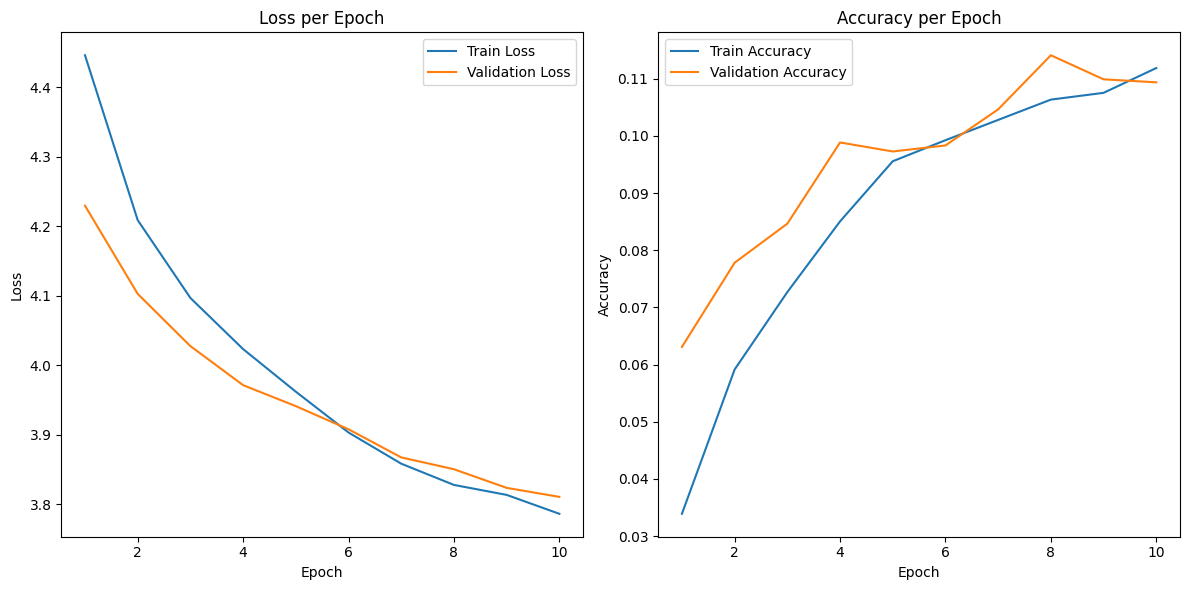

In [60]:
# Обучение модели с улучшениями
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=100)

train_model_with_callbacks(
    model, train_loader_basic, val_loader_basic, device, epochs=10, lr=1e-3, patience=3
)

#### 1.3. идем дальше, строим 3 модель, она будет с дополнительными преобразованиями картинок

ситуация похожа. 

In [86]:
train_dataset_advanced = CustomDatasetFromSamples(
    train_samples, transform=advanced_transform
)
val_dataset_advanced = CustomDatasetFromSamples(
    val_samples, transform=advanced_transform
)

train_loader_advanced = DataLoader(
    train_dataset_advanced, batch_size=64, shuffle=True, num_workers=2
)
val_loader_advanced = DataLoader(
    val_dataset_advanced, batch_size=64, shuffle=False, num_workers=2
)

Epoch 1/10 - Training: 100%|██████████| 119/119 [01:00<00:00,  1.95it/s]


Epoch 1/10 - Train Loss: 4.4725, Train Acc: 0.0333, Val Loss: 4.2963, Val Acc: 0.0531


Epoch 2/10 - Training: 100%|██████████| 119/119 [01:01<00:00,  1.94it/s]


Epoch 2/10 - Train Loss: 4.2797, Train Acc: 0.0496, Val Loss: 4.1890, Val Acc: 0.0641


Epoch 3/10 - Training: 100%|██████████| 119/119 [00:58<00:00,  2.02it/s]


Epoch 3/10 - Train Loss: 4.2130, Train Acc: 0.0531, Val Loss: 4.1523, Val Acc: 0.0647


Epoch 4/10 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.91it/s]


Epoch 4/10 - Train Loss: 4.1601, Train Acc: 0.0618, Val Loss: 4.1151, Val Acc: 0.0668


Epoch 5/10 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.92it/s]


Epoch 5/10 - Train Loss: 4.1275, Train Acc: 0.0664, Val Loss: 4.1057, Val Acc: 0.0694


Epoch 6/10 - Training: 100%|██████████| 119/119 [01:00<00:00,  1.97it/s]


Epoch 6/10 - Train Loss: 4.0835, Train Acc: 0.0724, Val Loss: 4.0517, Val Acc: 0.0815


Epoch 7/10 - Training: 100%|██████████| 119/119 [01:01<00:00,  1.93it/s]


Epoch 7/10 - Train Loss: 4.0596, Train Acc: 0.0747, Val Loss: 4.0633, Val Acc: 0.0778


Epoch 8/10 - Training: 100%|██████████| 119/119 [01:01<00:00,  1.94it/s]


Epoch 8/10 - Train Loss: 4.0535, Train Acc: 0.0757, Val Loss: 4.0293, Val Acc: 0.0815


Epoch 9/10 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.92it/s]


Epoch 9/10 - Train Loss: 4.0265, Train Acc: 0.0846, Val Loss: 4.0337, Val Acc: 0.0736


Epoch 10/10 - Training: 100%|██████████| 119/119 [01:01<00:00,  1.92it/s]


Epoch 10/10 - Train Loss: 4.0168, Train Acc: 0.0819, Val Loss: 4.0143, Val Acc: 0.0889


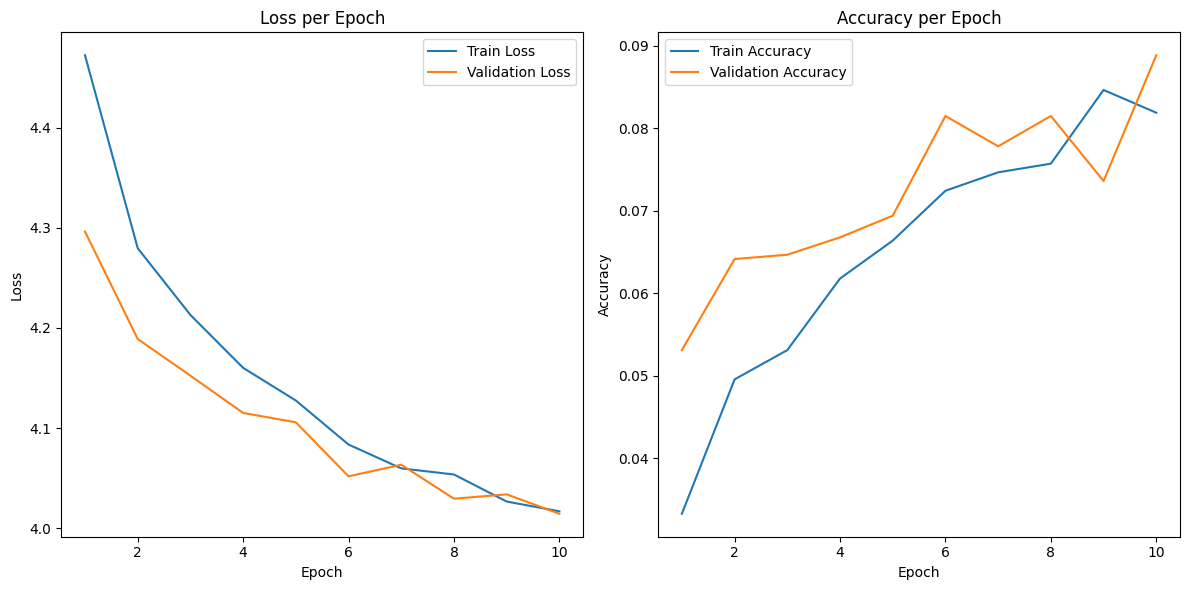

In [33]:
# Обучение модели с улучшениями
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=100)

train_model_with_callbacks(
    model,
    train_loader_advanced,
    val_loader_advanced,
    device,
    epochs=10,
    lr=1e-3,
    patience=3,
)

### 2.1 переходим к transfer learning. efficientnet


In [63]:
def create_efficientnet_model(num_classes=100, pretrained=True):
    weights = models.EfficientNet_B0_Weights.DEFAULT if pretrained else None
    model = efficientnet_b0(weights=weights)

    # Замораживаем все параметры
    for param in model.parameters():
        param.requires_grad = False

    # Заменяем последний слой классификатора
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Размораживаем только классификатор
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model

In [64]:

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = (
            gamma  # Параметр фокуса (по сути, как сильно усилить трудные примеры)
        )
        self.alpha = alpha  # Параметр для учета дисбаланса классов (где alpha * weight)

    def forward(self, inputs, targets):
        # Вычисляем стандартный Cross-Entropy Loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction="none")

        # Рассчитываем вероятности для каждого класса
        probs = torch.softmax(inputs, dim=1)

        # Получаем вероятность для правильного класса
        pt = probs.gather(
            1, targets.view(-1, 1)
        )  # Собираем вероятность для правильного класса

        # Focal loss: (1 - pt) ** gamma * BCE_loss
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        return loss.mean()  # Возвращаем усредненный лосс

### gamma контролирует, насколько сильно мы усиливаем трудные примеры, а alpha регулирует влияние классов с дисбалансом.

In [65]:



def train_transfer_model(
    model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3
):
    model.to(device)
    criterion = FocalLoss(gamma=2.0, alpha=0.25)

    # Используем Adam или другой оптимизатор
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Ранняя остановка
    best_val_loss = float("inf")
    patience_counter = 0

    # Переменные для отслеживания лосса и точности
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучение
        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # После обучения эпохи
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_transfer_model.pth")
            patience_counter = 0  # сброс счетчика
        else:
            patience_counter += 1

        # Ранняя остановка
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Обновление learning rate
        scheduler.step()

    # Построение графиков
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [88]:
import torch.optim.lr_scheduler as lr_scheduler


Epoch 1/50 - Training: 100%|██████████| 119/119 [00:11<00:00, 10.75it/s]


Epoch 1/50 - Train Loss: 0.9327, Train Acc: 0.1693, Val Loss: 0.7364, Val Acc: 0.2992


Epoch 2/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.53it/s]


Epoch 2/50 - Train Loss: 0.6406, Train Acc: 0.3178, Val Loss: 0.5428, Val Acc: 0.3370


Epoch 3/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.68it/s]


Epoch 3/50 - Train Loss: 0.5034, Train Acc: 0.3642, Val Loss: 0.4615, Val Acc: 0.3843


Epoch 4/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.94it/s]


Epoch 4/50 - Train Loss: 0.4450, Train Acc: 0.3899, Val Loss: 0.4136, Val Acc: 0.4054


Epoch 5/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.86it/s]


Epoch 5/50 - Train Loss: 0.4001, Train Acc: 0.4129, Val Loss: 0.3778, Val Acc: 0.4280


Epoch 6/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.92it/s]


Epoch 6/50 - Train Loss: 0.3723, Train Acc: 0.4253, Val Loss: 0.3745, Val Acc: 0.4211


Epoch 7/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.97it/s]


Epoch 7/50 - Train Loss: 0.3598, Train Acc: 0.4349, Val Loss: 0.3493, Val Acc: 0.4432


Epoch 8/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.90it/s]


Epoch 8/50 - Train Loss: 0.3552, Train Acc: 0.4386, Val Loss: 0.3545, Val Acc: 0.4259


Epoch 9/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.72it/s]


Epoch 9/50 - Train Loss: 0.3321, Train Acc: 0.4561, Val Loss: 0.3453, Val Acc: 0.4458


Epoch 10/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 13.01it/s]


Epoch 10/50 - Train Loss: 0.3307, Train Acc: 0.4482, Val Loss: 0.3506, Val Acc: 0.4348


Epoch 11/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.70it/s]


Epoch 11/50 - Train Loss: 0.3265, Train Acc: 0.4558, Val Loss: 0.3398, Val Acc: 0.4411


Epoch 12/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 13.11it/s]


Epoch 12/50 - Train Loss: 0.3224, Train Acc: 0.4600, Val Loss: 0.3460, Val Acc: 0.4322


Epoch 13/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.84it/s]


Epoch 13/50 - Train Loss: 0.3183, Train Acc: 0.4611, Val Loss: 0.3284, Val Acc: 0.4353


Epoch 14/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.75it/s]


Epoch 14/50 - Train Loss: 0.3155, Train Acc: 0.4644, Val Loss: 0.3495, Val Acc: 0.4190


Epoch 15/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.69it/s]


Epoch 15/50 - Train Loss: 0.3113, Train Acc: 0.4628, Val Loss: 0.3411, Val Acc: 0.4285


Epoch 16/50 - Training: 100%|██████████| 119/119 [00:09<00:00, 12.81it/s]


Epoch 16/50 - Train Loss: 0.3050, Train Acc: 0.4666, Val Loss: 0.3365, Val Acc: 0.4516
Early stopping triggered


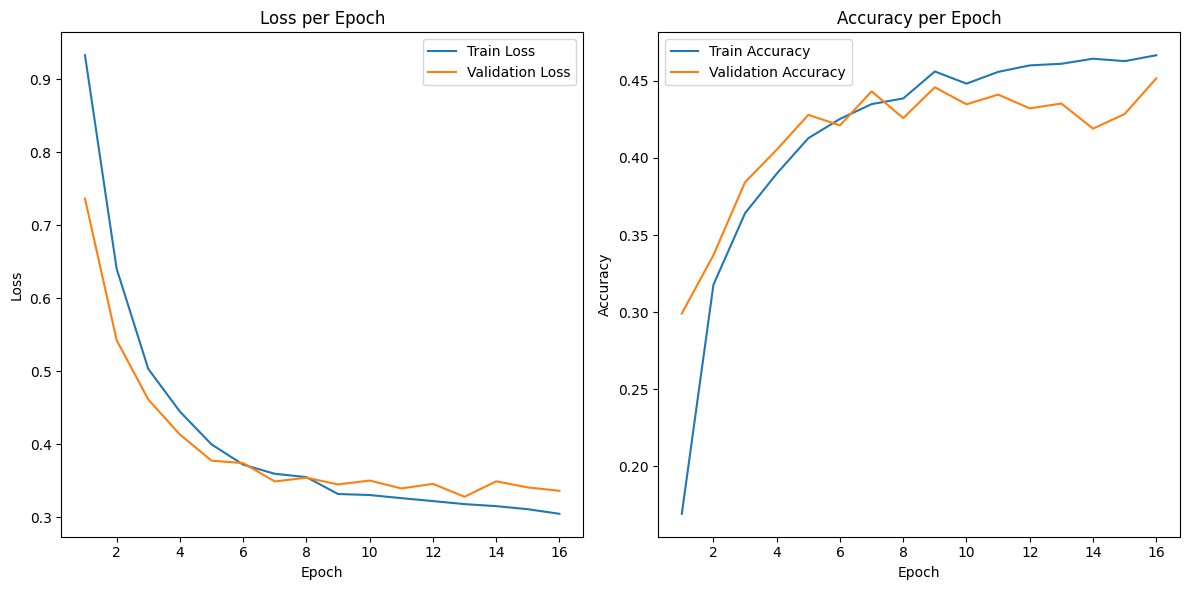

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfer = create_efficientnet_model(num_classes=100) 

train_transfer_model(
    model_transfer,
    train_loader_advanced,
    val_loader_advanced,
    device,
    epochs=50,
    lr=1e-3,
    patience=3,
)

### 2.2. посмотрим на resnet

In [48]:
def create_resnet_model(num_classes=100, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    for param in model.parameters():
        param.requires_grad = False  # Заморозить все слои, кроме последнего
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [49]:
def train_resnet_model(
    model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3
):
    model.to(device)
    criterion = FocalLoss(gamma=2.0, alpha=0.25)

    # Используем Adam 
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)  
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float("inf")
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучение
        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # После обучения эпохи
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_transfer_model.pth")
            patience_counter = 0  # сброс счетчика
        else:
            patience_counter += 1

        # Ранняя остановка
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Обновление learning rate
        scheduler.step()

    # Построение графиков
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.4MB/s]
Epoch 1/50 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.92it/s]


Epoch 1/50 - Train Loss: 0.9312, Train Acc: 0.1308, Val Loss: 0.7219, Val Acc: 0.2261


Epoch 2/50 - Training: 100%|██████████| 119/119 [00:58<00:00,  2.02it/s]


Epoch 2/50 - Train Loss: 0.6128, Train Acc: 0.2854, Val Loss: 0.5600, Val Acc: 0.2992


Epoch 3/50 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.92it/s]


Epoch 3/50 - Train Loss: 0.5003, Train Acc: 0.3399, Val Loss: 0.4856, Val Acc: 0.3381


Epoch 4/50 - Training: 100%|██████████| 119/119 [00:59<00:00,  1.99it/s]


Epoch 4/50 - Train Loss: 0.4330, Train Acc: 0.3670, Val Loss: 0.4335, Val Acc: 0.3749


Epoch 5/50 - Training: 100%|██████████| 119/119 [01:05<00:00,  1.83it/s]


Epoch 5/50 - Train Loss: 0.4010, Train Acc: 0.3877, Val Loss: 0.4311, Val Acc: 0.3759


Epoch 6/50 - Training: 100%|██████████| 119/119 [01:02<00:00,  1.90it/s]


Epoch 6/50 - Train Loss: 0.3591, Train Acc: 0.4209, Val Loss: 0.3804, Val Acc: 0.4001


Epoch 7/50 - Training: 100%|██████████| 119/119 [01:03<00:00,  1.89it/s]


Epoch 7/50 - Train Loss: 0.3461, Train Acc: 0.4292, Val Loss: 0.3871, Val Acc: 0.3901


Epoch 11/50 - Training: 100%|██████████| 119/119 [01:00<00:00,  1.97it/s]


Epoch 11/50 - Train Loss: 0.3112, Train Acc: 0.4550, Val Loss: 0.3546, Val Acc: 0.4075
Early stopping triggered


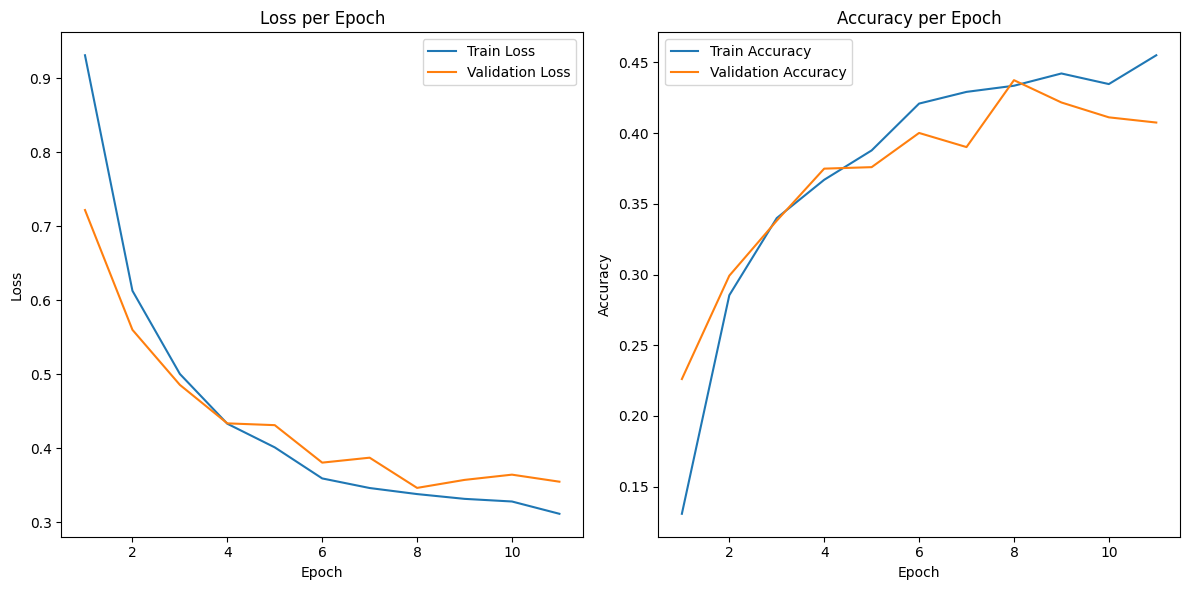

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = create_resnet_model(num_classes=100) 

train_resnet_model(
    model_resnet,
    train_loader_advanced,
    val_loader_advanced,
    device,
    epochs=50,
    lr=1e-3,
    patience=3,
)

### 2.3 посмотрим на densenet

In [104]:
IMG_SIZE = 224  

densenet_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),  
        # Геометрия
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
 
        # Цвет и освещение
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.4),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
        # Шумы и эффекты
       
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, p=0.3),  # затирание части изображения
        A.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  ##это параметры имаджнета, т.к. на нем училась моделька
        ToTensorV2(),
    ]
)

In [105]:
def create_densenet_model(num_classes=100, pretrained=True):
    model = models.densenet121(pretrained=pretrained)
    for param in model.parameters():
        param.requires_grad = False  
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

In [106]:
def train_densenet_model(
    model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3
):
    model.to(device)
    criterion = FocalLoss(
        gamma=2.0, alpha=0.25
    )  # Используем Focal Loss для борьбы с дисбалансом классов

    # Замораживаем все слои, кроме последнего
    for param in model.parameters():
        param.requires_grad = False
    # Размораживаем последний слой классификации
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Используем Adam или другой оптимизатор
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Ранняя остановка
    best_val_loss = float("inf")
    patience_counter = 0

    # Переменные для отслеживания лосса и точности
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучение
        for images, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"
        ):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # После обучения эпохи
        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Валидация
        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Сохраняем лучшую модель
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_densenet_model.pth")
            patience_counter = 0  # сброс счетчика
        else:
            patience_counter += 1

        # Ранняя остановка
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Обновление learning rate
        scheduler.step()

    # Построение графиков
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [107]:
train_dataset_densenet = CustomDatasetFromSamples(
    train_samples, transform=basic_transform
)
val_dataset_densenet = CustomDatasetFromSamples(
    val_samples, transform=basic_transform
)
train_loader_densenet = DataLoader(
    train_dataset_densenet, batch_size=64, shuffle=True, num_workers=2
)
val_loader_densenet = DataLoader(
    val_dataset_densenet, batch_size=64, shuffle=False, num_workers=2
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.27it/s]


Epoch 1/50 - Train Loss: 0.8823, Train Acc: 0.1752, Val Loss: 0.6349, Val Acc: 0.3034


Epoch 2/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.30it/s]


Epoch 2/50 - Train Loss: 0.5111, Train Acc: 0.3737, Val Loss: 0.4455, Val Acc: 0.4059


Epoch 3/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.29it/s]


Epoch 3/50 - Train Loss: 0.3647, Train Acc: 0.4653, Val Loss: 0.3501, Val Acc: 0.4522


Epoch 4/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.27it/s]


Epoch 4/50 - Train Loss: 0.2880, Train Acc: 0.5130, Val Loss: 0.3165, Val Acc: 0.4669


Epoch 5/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.25it/s]


Epoch 5/50 - Train Loss: 0.2495, Train Acc: 0.5405, Val Loss: 0.2891, Val Acc: 0.4795


Epoch 6/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.27it/s]


Epoch 6/50 - Train Loss: 0.2169, Train Acc: 0.5716, Val Loss: 0.2706, Val Acc: 0.5032


Epoch 7/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.24it/s]


Epoch 7/50 - Train Loss: 0.2053, Train Acc: 0.5820, Val Loss: 0.2588, Val Acc: 0.5105


Epoch 8/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.26it/s]


Epoch 8/50 - Train Loss: 0.1968, Train Acc: 0.5873, Val Loss: 0.2519, Val Acc: 0.5074


Epoch 9/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.24it/s]


Epoch 9/50 - Train Loss: 0.1836, Train Acc: 0.6027, Val Loss: 0.2512, Val Acc: 0.5126


Epoch 10/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.25it/s]


Epoch 10/50 - Train Loss: 0.1800, Train Acc: 0.6019, Val Loss: 0.2472, Val Acc: 0.5068


Epoch 11/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.24it/s]


Epoch 11/50 - Train Loss: 0.1645, Train Acc: 0.6262, Val Loss: 0.2295, Val Acc: 0.5336


Epoch 12/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.23it/s]


Epoch 12/50 - Train Loss: 0.1641, Train Acc: 0.6292, Val Loss: 0.2324, Val Acc: 0.5368


Epoch 13/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.22it/s]


Epoch 13/50 - Train Loss: 0.1606, Train Acc: 0.6282, Val Loss: 0.2339, Val Acc: 0.5273


Epoch 14/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.24it/s]


Epoch 14/50 - Train Loss: 0.1568, Train Acc: 0.6328, Val Loss: 0.2375, Val Acc: 0.5126
Early stopping triggered


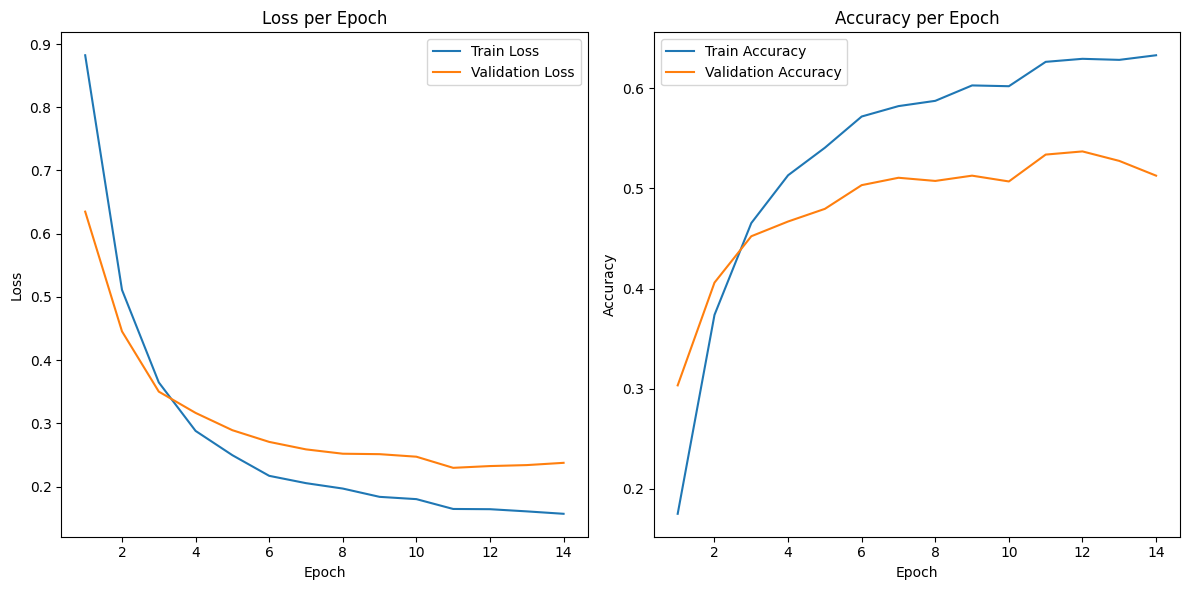

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet = create_densenet_model(num_classes=100)  # Укажи свой num_classes

train_densenet_model(
    model_densenet,
    train_loader_densenet,
    val_loader_densenet,
    device,
    epochs=50,
    lr=1e-3,
    patience=3,
)

### 2.4. посмотрим на inception

In [62]:
IMG_SIZE = 299  

inception_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),  
        # Геометрия
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
       
        # Цвет и освещение
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.4),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.3),
        # Шумы и эффекты
      
        A.CoarseDropout(
            max_holes=1, max_height=16, max_width=16, p=0.3
        ),  # затирание части изображения
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [63]:

from torchvision.models import Inception_V3_Weights

def create_inception_model(num_classes=100, weights=Inception_V3_Weights.DEFAULT):
    model = models.inception_v3(weights=weights)
    for param in model.parameters():
        param.requires_grad = False  # Заморозить все слои, кроме последнего
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [64]:

def train_inception_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Заморозка всех параметров
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)

            # Используем только основные logits
            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_inception_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        scheduler.step()


In [65]:
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Извлекаем основную часть из InceptionOutputs
            if hasattr(outputs, "logits"):
                outputs = outputs.logits

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss, val_acc


In [66]:
train_dataset_inception = CustomDatasetFromSamples(
    train_samples, transform=inception_transform
)
val_dataset_inception = CustomDatasetFromSamples(
    val_samples, transform=inception_transform
)

train_loader_inception = DataLoader(
    train_dataset_inception, batch_size=64, shuffle=True, num_workers=2
)
val_loader_inception = DataLoader(
    val_dataset_inception, batch_size=64, shuffle=False, num_workers=2
)

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = create_inception_model(num_classes=100)  # Укажи свой num_classes

train_inception_model(
    model_inception,
    train_loader_inception,
    val_loader_inception,
    device,
    epochs=50,
    lr=1e-3,
    patience=3,
)

Epoch 1/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.45it/s]


Epoch 1/50 - Train Loss: 4.1128, Train Acc: 0.1334, Val Loss: 3.5330, Val Acc: 0.2587


Epoch 2/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.44it/s]


Epoch 2/50 - Train Loss: 3.2257, Train Acc: 0.2965, Val Loss: 2.9836, Val Acc: 0.3491


Epoch 3/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.29it/s]


Epoch 3/50 - Train Loss: 2.8509, Train Acc: 0.3446, Val Loss: 2.7049, Val Acc: 0.3770


Epoch 4/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.48it/s]


Epoch 4/50 - Train Loss: 2.6528, Train Acc: 0.3661, Val Loss: 2.5402, Val Acc: 0.4012


Epoch 5/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.45it/s]


Epoch 5/50 - Train Loss: 2.5255, Train Acc: 0.3913, Val Loss: 2.4732, Val Acc: 0.4096


Epoch 6/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.47it/s]


Epoch 6/50 - Train Loss: 2.4105, Train Acc: 0.4079, Val Loss: 2.3684, Val Acc: 0.4206


Epoch 7/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.20it/s]


Epoch 7/50 - Train Loss: 2.3784, Train Acc: 0.4232, Val Loss: 2.3595, Val Acc: 0.4306


Epoch 8/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.42it/s]


Epoch 8/50 - Train Loss: 2.3197, Train Acc: 0.4298, Val Loss: 2.3410, Val Acc: 0.4259


Epoch 9/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.46it/s]


Epoch 9/50 - Train Loss: 2.3125, Train Acc: 0.4268, Val Loss: 2.3003, Val Acc: 0.4469


Epoch 10/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.26it/s]


Epoch 10/50 - Train Loss: 2.2718, Train Acc: 0.4348, Val Loss: 2.2700, Val Acc: 0.4359


Epoch 11/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.52it/s]


Epoch 11/50 - Train Loss: 2.2178, Train Acc: 0.4514, Val Loss: 2.2018, Val Acc: 0.4522


Epoch 12/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.30it/s]


Epoch 12/50 - Train Loss: 2.2150, Train Acc: 0.4455, Val Loss: 2.2268, Val Acc: 0.4485


Epoch 13/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.40it/s]


Epoch 13/50 - Train Loss: 2.2235, Train Acc: 0.4466, Val Loss: 2.2393, Val Acc: 0.4443


Epoch 14/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.48it/s]


Epoch 14/50 - Train Loss: 2.2132, Train Acc: 0.4507, Val Loss: 2.1944, Val Acc: 0.4564


Epoch 15/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.39it/s]


Epoch 15/50 - Train Loss: 2.2075, Train Acc: 0.4516, Val Loss: 2.2432, Val Acc: 0.4479


Epoch 16/50 - Training: 100%|██████████| 119/119 [00:16<00:00,  7.42it/s]


Epoch 16/50 - Train Loss: 2.1839, Train Acc: 0.4516, Val Loss: 2.2400, Val Acc: 0.4359


Epoch 17/50 - Training: 100%|██████████| 119/119 [00:15<00:00,  7.49it/s]


Epoch 17/50 - Train Loss: 2.1729, Train Acc: 0.4612, Val Loss: 2.2445, Val Acc: 0.4401
Early stopping triggered.


тут я решила в дебри сходить 

### Shifted Window Transformer.

слабо вышло

In [74]:

from torchvision.models import swin_t, Swin_T_Weights



In [75]:
def create_swin_model(num_classes=100, weights=Swin_T_Weights.DEFAULT):
    model = swin_t(weights=weights)
    for param in model.parameters():
        param.requires_grad = False  # Заморозить все слои
    model.head = nn.Linear(model.head.in_features, num_classes)  # Заменяем классификатор
    return model


In [76]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-3, patience=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.head.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, device, criterion)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_swin_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()


In [77]:
def evaluate_model(model, val_loader, device, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_loss, val_acc


In [82]:


IMG_SIZE = 224  

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

swin_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=3),  
    A.HorizontalFlip(p=0.5),  
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Сдвиг, масштабирование и поворот
    A.RandomBrightnessContrast(p=0.3),  # Случайная контрастность и яркость
    A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=0.5),  
    A.Normalize(mean=mean, std=std),  
    ToTensorV2(),  
])


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [83]:
# Создаем датасеты
train_dataset_transf = CustomDatasetFromSamples(
    train_samples, transform=swin_transform
)
val_dataset_transf = CustomDatasetFromSamples(
    val_samples, transform=swin_transform
)

# Даталоадеры
train_loader_transf = DataLoader(
    train_dataset_transf, batch_size=64, shuffle=True, num_workers=2
)
val_loader_transf = DataLoader(
    val_dataset_transf, batch_size=64, shuffle=False, num_workers=2
)

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_swin_model(num_classes=100)
train_model(model, train_loader_transf, val_loader_transf, device, epochs=10)


Epoch 1/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.37it/s]


Epoch 1: Train Loss=4.1766, Train Acc=0.0839 | Val Loss=3.7710, Val Acc=0.1462


Epoch 2/10 - Training: 100%|██████████| 119/119 [00:21<00:00,  5.41it/s]


Epoch 2: Train Loss=3.7337, Train Acc=0.1505 | Val Loss=3.5378, Val Acc=0.1798


Epoch 3/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.39it/s]


Epoch 3: Train Loss=3.5361, Train Acc=0.1757 | Val Loss=3.3842, Val Acc=0.2140


Epoch 4/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.36it/s]


Epoch 4: Train Loss=3.4076, Train Acc=0.2041 | Val Loss=3.2980, Val Acc=0.2124


Epoch 5/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.34it/s]


Epoch 5: Train Loss=3.3258, Train Acc=0.2086 | Val Loss=3.2193, Val Acc=0.2482


Epoch 6/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.33it/s]


Epoch 6: Train Loss=3.2375, Train Acc=0.2262 | Val Loss=3.1823, Val Acc=0.2529


Epoch 7/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.32it/s]


Epoch 7: Train Loss=3.2111, Train Acc=0.2346 | Val Loss=3.1453, Val Acc=0.2513


Epoch 8/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.31it/s]


Epoch 8: Train Loss=3.1798, Train Acc=0.2404 | Val Loss=3.1375, Val Acc=0.2492


Epoch 9/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.31it/s]


Epoch 9: Train Loss=3.1604, Train Acc=0.2466 | Val Loss=3.1177, Val Acc=0.2634


Epoch 10/10 - Training: 100%|██████████| 119/119 [00:22<00:00,  5.26it/s]


Epoch 10: Train Loss=3.1354, Train Acc=0.2458 | Val Loss=3.0770, Val Acc=0.2576


## много доработок по сравнению с подходом в базовых и предыдущих модельках


норм - вайдризнет_50 с резом 0.76 на тесте в кагл (код ниже, в последствии заменила модель на convnext и подняла результат.

In [158]:
## https://github.com/facebookresearch/ConvNeXt

по сути это сверточная сеть, эдакая комбинация ризнетов, которая при этом дополнена всякими фичами в вычислениях из трансформеров

https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_A_ConvNet_for_the_2020s_CVPR_2022_paper.pdf


## моя лучшая модель ! convnext_base скор 0.89

In [96]:
###swin_base_patch4_window7_224 пробовала. на трейне рез 0.84 !

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [142]:
# Параметры
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
EARLY_STOP_PATIENCE = 3

In [143]:
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']
        return img, label

In [144]:
def get_stratified_datasets(root_dir, test_size=0.2):
    samples, labels = [], []
    classes = sorted(os.listdir(root_dir))
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if os.path.isdir(cls_dir):
            for f in os.listdir(cls_dir):
                samples.append((os.path.join(cls_dir, f), int(cls)))
                labels.append(int(cls))
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_idx, val_idx = next(splitter.split(samples, labels))
    return [samples[i] for i in train_idx], [samples[i] for i in val_idx]


In [145]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.2),
    A.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    max_pixel_value=255.0
    ),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    max_pixel_value=255.0
    ),
    ToTensorV2()
])


In [146]:
def compute_class_weights(samples, num_classes):
    counts = Counter(label for _, label in samples)
    total = sum(counts.values())
    weights = [total / (num_classes * counts[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [147]:

def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam


In [148]:
train_samples, val_samples = get_stratified_datasets('data_split/train')
class_names = sorted({label for _, label in train_samples + val_samples})

train_ds = CustomImageDataset(train_samples, train_transform)
val_ds = CustomImageDataset(val_samples, val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [149]:
# Модель convnext_base
model = timm.create_model('convnext_base', pretrained=True, num_classes=len(class_names), drop_rate=0.2)
model.to(device)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [150]:
for p in model.parameters():
    p.requires_grad = False
for p in model.get_classifier().parameters():
    p.requires_grad = True

In [151]:
from torch.optim.lr_scheduler import OneCycleLR


In [152]:
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-2)
scheduler = OneCycleLR(
    optimizer, max_lr=3e-4,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)


In [153]:
# Критерий с учетом весов
class_weights = compute_class_weights(train_samples, len(class_names)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

In [154]:

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

Epoch 1/30: 100%|██████████| 190/190 [00:42<00:00,  4.43it/s]


Epoch 1/30   Train Loss: 4.8870, Train Acc: 1.17%   Val Loss: 4.6472, Val Acc: 3.30%


Epoch 2/30: 100%|██████████| 190/190 [00:40<00:00,  4.67it/s]


Epoch 2/30   Train Loss: 4.5836, Train Acc: 4.14%   Val Loss: 4.1255, Val Acc: 20.73%


Epoch 3/30: 100%|██████████| 190/190 [00:40<00:00,  4.66it/s]


Epoch 3/30   Train Loss: 4.0261, Train Acc: 15.87%   Val Loss: 3.2561, Val Acc: 58.68%


Epoch 4/30: 100%|██████████| 190/190 [02:18<00:00,  1.37it/s]


Epoch 4/30   Train Loss: 3.3780, Train Acc: 29.98%   Val Loss: 2.7618, Val Acc: 71.68%


Epoch 5/30: 100%|██████████| 190/190 [02:19<00:00,  1.36it/s]


Epoch 5/30   Train Loss: 2.9130, Train Acc: 37.82%   Val Loss: 2.0788, Val Acc: 81.91%


IOStream.flush timed out
Epoch 6/30: 100%|██████████| 190/190 [02:19<00:00,  1.37it/s]


Epoch 6/30   Train Loss: 2.3791, Train Acc: 42.91%   Val Loss: 1.5003, Val Acc: 87.99%


Epoch 7/30: 100%|██████████| 190/190 [02:19<00:00,  1.36it/s]


Epoch 7/30   Train Loss: 2.0924, Train Acc: 45.15%   Val Loss: 1.4002, Val Acc: 87.72%


Epoch 8/30: 100%|██████████| 190/190 [02:19<00:00,  1.36it/s]


Epoch 8/30   Train Loss: 1.9399, Train Acc: 51.11%   Val Loss: 1.2671, Val Acc: 89.97%


Epoch 9/30: 100%|██████████| 190/190 [02:20<00:00,  1.35it/s]


Epoch 9/30   Train Loss: 1.8381, Train Acc: 42.22%   Val Loss: 1.2650, Val Acc: 88.98%


Epoch 10/30: 100%|██████████| 190/190 [02:20<00:00,  1.36it/s]


Epoch 10/30   Train Loss: 1.7548, Train Acc: 44.73%   Val Loss: 1.2534, Val Acc: 89.24%


Epoch 11/30: 100%|██████████| 190/190 [02:19<00:00,  1.36it/s]


Epoch 11/30   Train Loss: 1.7539, Train Acc: 51.46%   Val Loss: 1.2989, Val Acc: 88.98%
Early stopping


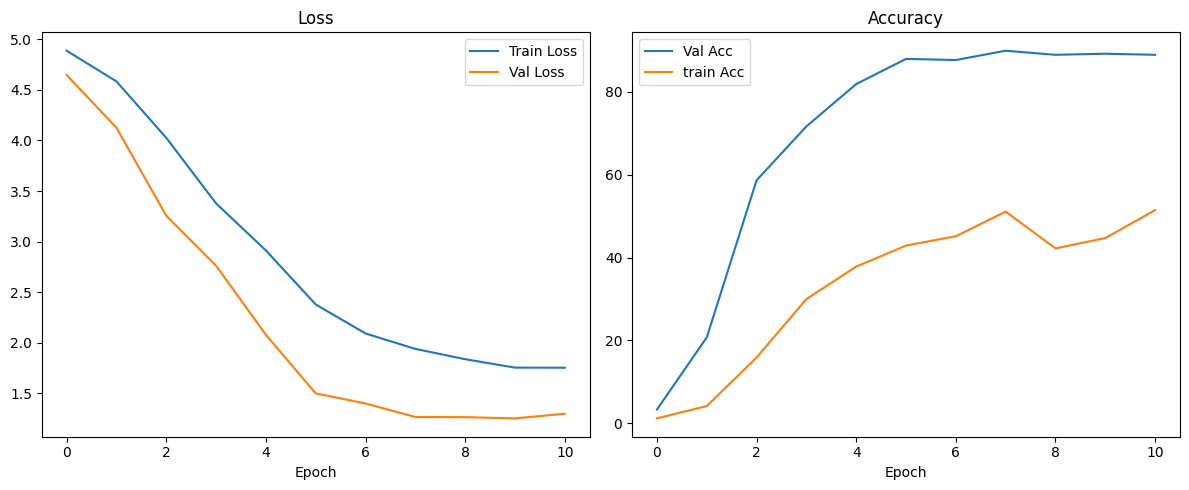

Best Validation Accuracy: 89.97%


In [155]:


best_val_acc = 0
no_improve = 0

for epoch in range(EPOCHS):
    if epoch == 3:
        for p in model.parameters(): p.requires_grad = True
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
        scheduler = OneCycleLR(optimizer, max_lr=1e-4,
                               steps_per_epoch=len(train_loader),
                               epochs=EPOCHS-epoch)

    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        mixed_imgs, y_a, y_b, lam = mixup_data(imgs, labels)
        optimizer.zero_grad()
        outputs = model(mixed_imgs)
        loss = lam * criterion(outputs, y_a) + (1-lam) * criterion(outputs, y_b)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_a).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

# Валидация
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)

    val_loss /= val_total
    val_acc = 100 * val_correct / val_total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}  ",
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%  ",
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print("Early stopping")
            break

# Построение графиков
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Acc')
plt.plot(history['train_acc'], label='train Acc')

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


In [156]:

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        fnames = [f for f in os.listdir(img_dir) if f.endswith('.png') and f.split('.')[0].isdigit()]
        self.paths = sorted(fnames, key=lambda x: int(x.split('.')[0]))
        self.paths = [os.path.join(img_dir, f) for f in self.paths]
        self.tf = transform

    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        img = self.tf(image=img)['image']
        return img, os.path.splitext(os.path.basename(p))[0]

test_tf = A.Compose([A.Resize(IMG_SIZE,IMG_SIZE), A.Normalize(), ToTensorV2()])
test_ds = TestDataset("test", transform=test_tf)
test_ld = DataLoader(test_ds, batch_size=32, shuffle=False)

# load best
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

subs = []
with torch.no_grad():
    for imgs, ids in tqdm(test_ld, desc="Predicting"):
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(1).cpu().numpy()
        for i, id_ in enumerate(ids):
            subs.append({"id": id_, "target": int(preds[i])})

pd.DataFrame(subs).to_csv("submission.csv", index=False)
print("submission.csv готов")


Predicting: 100%|██████████| 122/122 [00:26<00:00,  4.55it/s]

submission.csv готов


## 4 генерация 

In [159]:

import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [160]:
# 1. Настройки
latent_dim = 100
num_classes = 100
img_size = 32
channels = 3
batch_size = 128
epochs_gan = 100
train_dir = './train'  
save_dir = './train_generated'  


In [161]:

for class_idx in range(num_classes):
    os.makedirs(os.path.join(save_dir, str(class_idx)), exist_ok=True)

print("Копируем оригинальные изображения:")
for class_idx in range(num_classes):
    src_class_dir = os.path.join(train_dir, str(class_idx))
    dst_class_dir = os.path.join(save_dir, str(class_idx))
    if os.path.exists(src_class_dir):
        for img_name in os.listdir(src_class_dir):
            src_img_path = os.path.join(src_class_dir, img_name)
            dst_img_path = os.path.join(dst_class_dir, img_name)
            shutil.copy2(src_img_path, dst_img_path)

Копируем оригинальные изображения:


In [162]:

print('Определяем BigGAN-lite Generator и Discriminator')
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, 128)
        self.init_size = img_size // 4
        self.fc = nn.Linear(latent_dim + 128, 256 * self.init_size * self.init_size)

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        out = self.fc(gen_input)
        out = out.view(out.shape[0], 256, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Определяем BigGAN-lite Generator и Discriminator


In [163]:

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, img_size * img_size)

        self.model = nn.Sequential(
            nn.Conv2d(channels + 1, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 3, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * (img_size // 8) * (img_size // 8), 1)
        )

    def forward(self, img, labels):
        label_maps = self.label_emb(labels).view(labels.size(0), 1, img_size, img_size)
        d_in = torch.cat((img, label_maps), dim=1)
        validity = self.model(d_in)
        return validity


In [164]:

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*channels, [0.5]*channels)
])
dataset = ImageFolder(root=train_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()


In [165]:


G_losses, D_losses = [], []
for epoch in range(epochs_gan):
    for imgs, labels in dataloader:
        batch_size_curr = imgs.size(0)

        real = torch.ones(batch_size_curr, 1, device=device)
        fake = torch.zeros(batch_size_curr, 1, device=device)

        imgs, labels = imgs.to(device), labels.to(device)

        # Обучаем дискриминатор
        optimizer_D.zero_grad()
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        gen_imgs = generator(z, gen_labels)

        real_loss = criterion(discriminator(imgs, labels), real)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Обучаем генератор
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, gen_labels), real)
        g_loss.backward()
        optimizer_G.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{epochs_gan}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")


[Epoch 1/100] D loss: 0.6226, G loss: 0.8060
[Epoch 2/100] D loss: 0.6838, G loss: 0.7669
[Epoch 3/100] D loss: 0.6515, G loss: 0.7540
[Epoch 4/100] D loss: 0.6834, G loss: 0.7283
[Epoch 5/100] D loss: 0.6731, G loss: 0.7864
[Epoch 6/100] D loss: 0.6871, G loss: 0.7413
[Epoch 7/100] D loss: 0.7270, G loss: 0.7708
[Epoch 8/100] D loss: 0.6725, G loss: 0.7336
[Epoch 9/100] D loss: 0.6743, G loss: 0.8075
[Epoch 10/100] D loss: 0.6890, G loss: 0.7487
[Epoch 11/100] D loss: 0.6889, G loss: 0.7377
[Epoch 12/100] D loss: 0.6990, G loss: 0.7153
[Epoch 13/100] D loss: 0.6755, G loss: 0.7072
[Epoch 14/100] D loss: 0.6930, G loss: 0.7592
[Epoch 15/100] D loss: 0.6930, G loss: 0.7640
[Epoch 16/100] D loss: 0.7147, G loss: 0.7033
[Epoch 17/100] D loss: 0.6938, G loss: 0.7068
[Epoch 18/100] D loss: 0.6932, G loss: 0.7639
[Epoch 19/100] D loss: 0.6805, G loss: 0.7513
[Epoch 20/100] D loss: 0.6741, G loss: 0.7624
[Epoch 21/100] D loss: 0.6769, G loss: 0.7969
[Epoch 22/100] D loss: 0.6801, G loss: 0.76

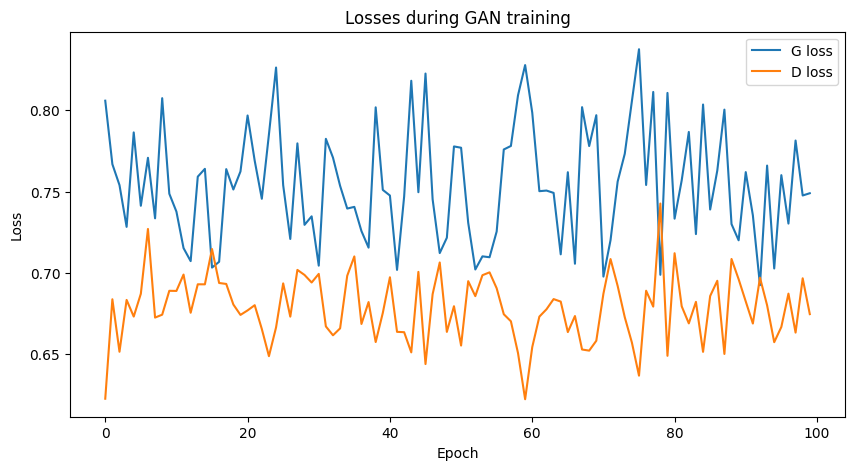

Генерация изображений:
Вывод примеров:


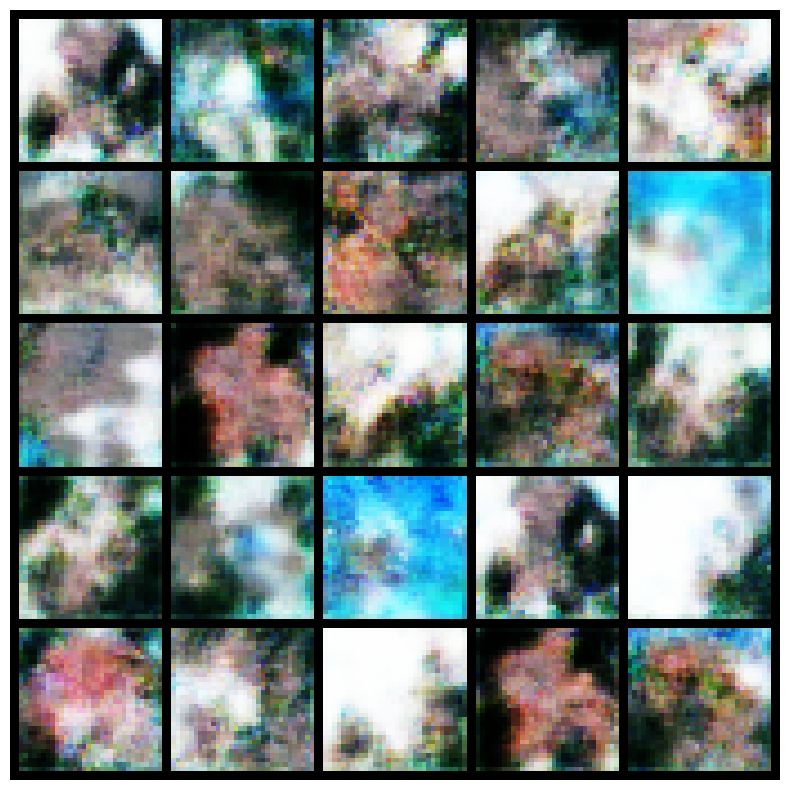

Генерация и сохранение завершены


In [166]:

# Графики лоссов
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='G loss')
plt.plot(D_losses, label='D loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses during GAN training')
plt.show()

print("Генерация изображений:")
num_gen_per_class = 500  # сколько картинок на каждый класс

with torch.no_grad():
    for class_idx in range(num_classes):
        z = torch.randn(num_gen_per_class, latent_dim, device=device)
        labels = torch.full((num_gen_per_class,), class_idx, dtype=torch.long, device=device)
        gen_imgs = generator(z, labels)
        gen_imgs = (gen_imgs + 1) / 2  # обратно в [0,1]

        class_path = os.path.join(save_dir, str(class_idx))
        for idx, img in enumerate(gen_imgs):
            save_image(img, os.path.join(class_path, f"gen_{idx}.png"))

# 7. Отображение нескольких примеров
print("Вывод примеров:")
z = torch.randn(25, latent_dim, device=device)
labels = torch.randint(0, num_classes, (25,), device=device)
sample_imgs = generator(z, labels)
sample_imgs = (sample_imgs + 1) / 2

grid = torchvision.utils.make_grid(sample_imgs.cpu(), nrow=5)
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

print("Генерация и сохранение завершены")



т.к. использовался простой генератор, собранный на коленке и обученный на не самых качественных изображениях, то акуреси на таких данных (плюс ориг данные) упало. что и ожидалось.

скор на кагл выбит с помощью 
## моя лучшая модель ! convnext_base скор 0.89 - модель над п.4 , генерация